In [42]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [43]:
cid = "f37bdaae60994d17b019127237812444"
secret = "e2a5dd85540e41fea85b92cbfcf92d45"

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [44]:
def create_df_from_playlist(playlist_link: str, save: int):
    playlist_URI = playlist_link.split("/")[-1].split("?")[0]
    track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]
    
    features = sp.audio_features(track_uris[0])[0]
    cols = ["track_name", "id", "track_pop", "artist_name", "artist_pop", "artist_genre"]
    cols.extend(list(features.keys()))
    cols.append("save")
    df = pd.DataFrame(columns=cols)
    
    for curr_uri in track_uris:
        row = []
        track = sp.track(curr_uri)
        row.append(track["name"])
        row.append(curr_uri)
        track_pop = row.append(track["popularity"])
        artist_uri = track["artists"][0]["uri"]
        artist_info = sp.artist(artist_uri) 
        #Name, popularity, genre
        artist_name = row.append(track["artists"][0]["name"])
        artist_pop = row.append(artist_info["popularity"])
        artist_genres = row.append(artist_info["genres"])
        
        features = sp.audio_features(curr_uri)[0]
        # print(features)
        
        row.extend(list(features.values()))
        row.append(save)
        
        new_row = pd.DataFrame([row], columns=df.columns)
        
        # Append the new row to df
        df = pd.concat([df, new_row], ignore_index=True)
    return df

In [63]:
good = create_df_from_playlist("https://open.spotify.com/playlist/6vOYm55EbfPnFpAgZynn6I?si=9070e8f011494eb0", 1)
# good2 = create_df_from_playlist("https://open.spotify.com/playlist/1bb77h4aEV7sutQ8EIvrL9?si=4ed01da7142d4f72", 1)
bad = create_df_from_playlist("https://open.spotify.com/playlist/5Dflf6jWmbFbpgjsJV4cwI?si=36def02aab974355", 0)

df = pd.concat([good, bad], ignore_index=True)
df

ReadTimeout: HTTPSConnectionPool(host='api.spotify.com', port=443): Read timed out. (read timeout=5)

Feature Engineering

In [52]:
feature_cols = ["track_pop", "artist_pop", "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "tempo", "duration_ms", "time_signature"]

X = df[feature_cols]
y = df["save"]
y = y.astype(int)

Correlation Heatmap between features

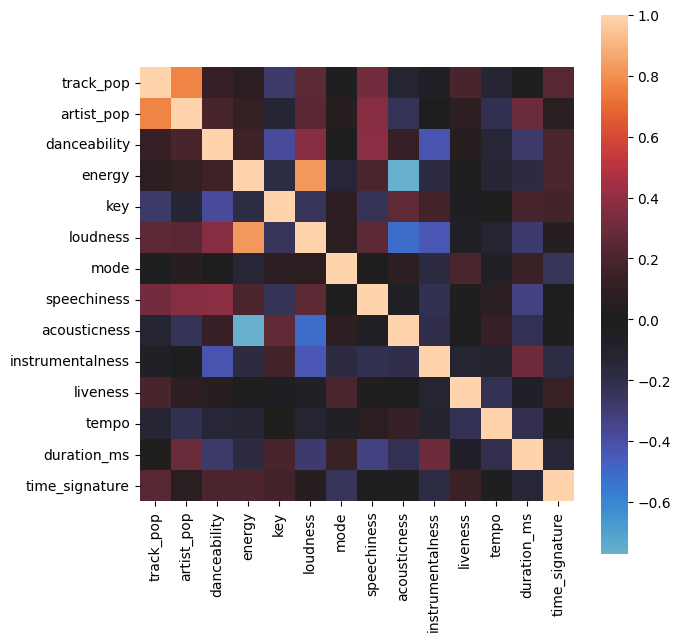

In [47]:
import seaborn as sns
plt.gcf().set_size_inches(7, 7)
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(X.corr(), center=0, annot=False, square=True)
plt.show()

In [55]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X.replace([np.inf, -np.inf], np.nan, inplace=True)

# After replacing inf values with NaN, you can choose to either drop or fill those as well
missing_or_infinite_values = X.isnull().any().any()

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

C:\Users\kiera\AppData\Local\Temp\ipykernel_33052\1383783196.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)


Accuracy

In [57]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred, normalize=True)

0.875

Confusion Matrix

In [60]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred, normalize='all')

array([[0.625, 0.125],
       [0.   , 0.25 ]])

### Precision, Recall, F1-Score, and Support where index 0 is for the class 0 and index 1 is for the class 1

In [61]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_test, y_pred)

(array([1.        , 0.66666667]),
 array([0.83333333, 1.        ]),
 array([0.90909091, 0.8       ]),
 array([6, 2], dtype=int64))

Conclusion: Poor precision, high accuracy